
# Verificação Facial — Colab/Local (Webcam + Preview)  
**Detecção (Haar), Pré-processamento, LBPH em memória, Liveness passivo, Calibração, Autenticação 1:1 e 1:N**

Este notebook inclui:
- Instalação compatível (NumPy 1.26.4 + OpenCV 4.8.1.78).
- **Webcam persistente + Preview - Verificação Facial Dual (Colab ↔ Local) - Detecta ambiente (IN_COLAB = True/False)**
- Preview ao vivo do **vídeo bruto** (opcional) e do **frame processado**.
- Detecção de face (Haar), **pré-processamento (CLAHE + blur)**.
- **Treino LBPH em memória** (sem `read()`/`write()` do modelo para evitar corrupção).
- **Calibração automática** que atualiza `SERVICE_THRESHOLD`.
- **Liveness passivo** por energia de movimento com preview.
- **Autenticação 1:1** e **1:N** com flows dedicados.
- **Evidências** opcionais (frames de falhas) em `cv_colab_data/evidence/`.


## 1) Instalação (reinicie o runtime após rodar)

In [1]:
# Recomendado: após executar, vá em Runtime > Restart runtime
#!pip uninstall -y opencv-python opencv-contrib-python numpy
!pip install --no-cache-dir numpy==1.26.4 opencv-contrib-python==4.8.1.78 matplotlib

import cv2, numpy as np
print("OpenCV:", cv2.__version__)
print("NumPy:", np.__version__)
try:
    _ = cv2.face.LBPHFaceRecognizer_create()
    print("cv2.face OK")
except Exception as e:
    print("Falha cv2.face:", e)

OpenCV: 4.8.1
NumPy: 1.26.4
cv2.face OK


## 2) Imports, diretórios e parâmetros

In [2]:
import base64, json, time, uuid, math
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import Javascript, display

# Estrutura de pastas
DATA_DIR = Path("cv_colab_data")
ENROLL_DIR = DATA_DIR/"enroll"
EVIDENCE_DIR = DATA_DIR/"evidence"
for d in (DATA_DIR, ENROLL_DIR, EVIDENCE_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Parâmetros globais (ajuste conforme sua calibração/ambiente)
SERVICE_THRESHOLD = 55.0       # será ajustado automaticamente na calibração
LIVENESS_MIN_ENERGY = 8.0      # energia mínima média para ser "live"

def show_bgr(img, title="preview"):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,4))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

## 3) Pré-processamento (CLAHE + blur)

In [3]:
def preprocess_face_gray(gray_200x200):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g = clahe.apply(gray_200x200)
    g = cv2.GaussianBlur(g, (3,3), 0)
    return g

## 4) Webcam persistente + Preview - Verificação Facial Dual (Colab ↔ Local)

In [4]:
import time, base64, uuid
from pathlib import Path
import numpy as np
import cv2

# Detecta ambiente
IN_COLAB = True
try:
    from google.colab import output  # só existe no Colab
    from IPython.display import Javascript, display
    IN_COLAB = True
except Exception:
    IN_COLAB = False

print("IN_COLAB =", IN_COLAB)

# ---------- (opcional) janela processada no Colab ----------
def update_display_img(frame_bgr):
    """
    Atualiza a <img id='output'> no Colab. Em ambiente local, essa função não faz nada
    (use cv2.imshow no seu fluxo local).
    """
    if not IN_COLAB:
        return
    ok, buffer = cv2.imencode('.jpg', frame_bgr)
    if not ok:
        return
    b64 = base64.b64encode(buffer).decode('utf-8')
    output.eval_js(f"window.updateProcessed && window.updateProcessed('{b64}')")

# ---------- Colab: stream persistente via JS ----------
if IN_COLAB:
    def _ensure_camera_ready(show_raw=False, width=640, height=480):
        js = f"""
        (async () => {{
          let container = document.getElementById('camera-container');
          if (!container) {{
            container = document.createElement('div');
            container.id = 'camera-container';
            container.style = 'display:flex; gap:12px; align-items:flex-start; justify-content:center; flex-wrap:wrap;';
            document.body.appendChild(container);
            container.innerHTML = `
              <div id="cam-left" style="display:{'flex' if show_raw else 'none'}; flex-direction:column; align-items:center; gap:6px;">
                <video id="webcam" autoplay playsinline muted style="max-width:{width}px; border:1px solid #ddd; border-radius:8px;"></video>
                <small style="color:#555">Pré-visualização (ao vivo)</small>
              </div>
              <div id="cam-right" style="display:flex; flex-direction:column; align-items:center; gap:6px;">
                <img id="output" style="max-width:{width}px; border:1px solid #ddd; border-radius:8px;">
                <small style="color:#555">Frame processado</small>
              </div>
              <canvas id="canvas" style="display:none;"></canvas>
            `;
          }} else {{
            const left = document.getElementById('cam-left');
            if (left) left.style.display = { '"flex"' if show_raw else '"none"' };
          }}

          if (!window._colabStream || window._colabStreamInactive) {{
            try {{
              window._colabStream = await navigator.mediaDevices.getUserMedia({{ video: {{width:{width}, height:{height}}}, audio:false }});
              window._colabStreamInactive = false;
            }} catch (e) {{
              console.error('getUserMedia failed', e);
              return false;
            }}
          }}
          const video = document.getElementById('webcam');
          if (video && video.srcObject !== window._colabStream) {{
            video.srcObject = window._colabStream;
          }}

          const canvas = document.getElementById('canvas');
          window.captureFrame = () => {{
            const ctx = canvas.getContext('2d');
            const vw = (video && video.videoWidth) ? video.videoWidth : {width};
            const vh = (video && video.videoHeight) ? video.videoHeight : {height};
            canvas.width = vw; canvas.height = vh;
            if (video) ctx.drawImage(video, 0, 0, vw, vh);
            return canvas.toDataURL('image/jpeg', 0.9);
          }};
          window.updateProcessed = (b64) => {{
            const img = document.getElementById('output');
            if (img) img.src = 'data:image/jpeg;base64,' + b64;
          }};
          window.stopColabCamera = () => {{
            try {{
              if (window._colabStream && !window._colabStreamInactive) {{
                window._colabStream.getTracks().forEach(t => t.stop());
                window._colabStreamInactive = true;
              }}
            }} catch (e) {{ console.warn(e); }}
            const c = document.getElementById('camera-container');
            if (c) c.remove();
          }};
          return true;
        }} )();
        """
        display(Javascript(js))
        time.sleep(0.2)

    def _b64_to_image(data_url_or_b64):
        if data_url_or_b64 is None:
            return None
        s = data_url_or_b64
        if isinstance(s, bytes):
            s = s.decode("utf-8")
        if s.startswith("data:image"):
            s = s.split(",")[1]
        arr = np.frombuffer(base64.b64decode(s), dtype=np.uint8)
        return cv2.imdecode(arr, cv2.IMREAD_COLOR)

    def capture_one(width=640, height=480, show_raw=False):
        _ensure_camera_ready(show_raw=show_raw, width=width, height=height)
        data_url = output.eval_js("window.captureFrame ? window.captureFrame() : null")
        return _b64_to_image(data_url)

    def capture_sequence(n=24, delay_ms=80, width=640, height=480, show_raw=False, preview_callback=None):
        _ensure_camera_ready(show_raw=show_raw, width=width, height=height)
        frames = []
        for i in range(n):
            data_url = output.eval_js("window.captureFrame ? window.captureFrame() : null")
            img = _b64_to_image(data_url)
            if img is not None:
                frames.append(img)
                if callable(preview_callback):
                    preview_callback(img, i)
            time.sleep(max(0, delay_ms/1000.0))
        return frames

    def stop_camera_ui():
        display(Javascript("if (window.stopColabCamera) window.stopColabCamera();"))
        time.sleep(0.2)

# ---------- Local: OpenCV VideoCapture ----------
else:
    def capture_one(cam_index=0, width=640, height=480, show_raw=False):
        cap = cv2.VideoCapture(cam_index)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH,  width)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        ret, frame = cap.read()
        cap.release()
        if not ret:
            raise RuntimeError("Não conseguiu capturar frame da webcam local")
        return frame

    def capture_sequence(n=24, delay_ms=80, cam_index=0, width=640, height=480, show_raw=False, preview_callback=None):
        cap = cv2.VideoCapture(cam_index)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH,  width)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        frames = []
        for i in range(n):
            ret, frame = cap.read()
            if not ret:
                continue
            frames.append(frame)
            if callable(preview_callback):
                preview_callback(frame, i)
            # preview simples local
            cv2.imshow("preview", frame)
            if cv2.waitKey(delay_ms) & 0xFF == ord("q"):
                break
        cap.release()
        cv2.destroyAllWindows()
        return frames

    def stop_camera_ui():
        # no local, apenas fecha janelas
        cv2.destroyAllWindows()

IN_COLAB = True


## 5) Detecção de faces (Haar/DNN)

In [5]:
# ============================
# 5) Detecção de faces (Haar/DNN)
# ============================
#
# Suporta dois detectores:
#   - "haar": Haar Cascade (cv2.CascadeClassifier)
#   - "dnn_ssd_resnet10": DNN (SSD ResNet10) via OpenCV DNN (Caffe)
#
# Escolha temporária (até o Runner setar automaticamente):
#   - Ajuste DETECTION_MODEL = "haar" | "dnn_ssd_resnet10"
#   - ou exporte a env: DETECTION_MODEL=haar | dnn_ssd_resnet10
#
# Uso: faces = detect_faces(img_bgr, conf_threshold=0.5)
# Retorno: lista de (x, y, w, h, score)

import os
import cv2
import numpy as np
from pathlib import Path

# ======================
# Configuração do modelo
# ======================
DETECTION_MODEL = os.environ.get("DETECTION_MODEL", "haar").strip().lower()

# Honra o DATA_DIR definido em outra célula; se não existir, cria um default
try:
    DATA_DIR  # definido na sua célula de diretórios
except NameError:
    DATA_DIR = Path("cv_colab_data")
    DATA_DIR.mkdir(parents=True, exist_ok=True)

MODELS_DIR = DATA_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Haar: caminho padrão do OpenCV (com fallback)
try:
    import cv2.data as cvd
    HAAR_PATH = str(Path(cvd.haarcascades) / "haarcascade_frontalface_default.xml")
except Exception:
    # fallback: se quiser manter tudo em DATA_DIR/models, pode copiar o xml pra lá
    HAAR_PATH = str(MODELS_DIR / "haarcascade_frontalface_default.xml")

# DNN (SSD ResNet10): caminhos dentro de DATA_DIR/models
DNN_PROTO_PATH   = MODELS_DIR / "deploy.prototxt"
# usamos o modelo Caffe "não-fp16", disponível publicamente:
DNN_WEIGHTS_PATH = MODELS_DIR / "res10_300x300_ssd_iter_140000.caffemodel"

# URLs oficiais/alternativas
DNN_PROTO_URL   = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
DNN_WEIGHTS_URL = "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

# --------------
# Inicialização
# --------------
_haar_cascade = None
_dnn_net = None

def _download_file(url: str, dest: Path) -> bool:
    """
    Baixa com urllib; se falhar e houver 'wget', tenta wget.
    Retorna True se o arquivo existir ao final.
    """
    dest.parent.mkdir(parents=True, exist_ok=True)
    try:
        import urllib.request
        print(f"Baixando {dest.name} …")
        urllib.request.urlretrieve(url, str(dest))
        return dest.exists()
    except Exception as e:
        print(f"Aviso: urllib falhou ({e}). Tentando wget (se disponível)…")
        try:
            code = os.system(f"wget -q -O {dest} {url}")
            return dest.exists() and code == 0
        except Exception as e2:
            print(f"Aviso: wget também falhou ({e2}).")
            return dest.exists()

def _download_if_missing():
    ok = True
    if not Path(DNN_PROTO_PATH).exists():
        ok = _download_file(DNN_PROTO_URL, DNN_PROTO_PATH) and ok
    if not Path(DNN_WEIGHTS_PATH).exists():
        ok = _download_file(DNN_WEIGHTS_URL, DNN_WEIGHTS_PATH) and ok
    if not ok:
        print(
            "[DNN] Não foi possível garantir todos os arquivos.\n"
            f"  Prototxt: {DNN_PROTO_PATH}\n"
            f"  Pesos   : {DNN_WEIGHTS_PATH}\n"
            "  → Baixe manualmente ou defina DNN_PROTO_PATH / DNN_WEIGHTS_PATH."
        )

def _init_haar():
    global _haar_cascade
    if _haar_cascade is None:
        if not os.path.exists(HAAR_PATH):
            raise FileNotFoundError(f"Haar cascade não encontrado em: {HAAR_PATH}")
        _haar_cascade = cv2.CascadeClassifier(HAAR_PATH)

def _init_dnn():
    _download_if_missing()
    global _dnn_net
    if _dnn_net is None:
        if not (Path(DNN_PROTO_PATH).exists() and Path(DNN_WEIGHTS_PATH).exists()):
            raise FileNotFoundError(
                "Arquivos do DNN não encontrados.\n"
                f"  Prototxt: {DNN_PROTO_PATH}\n"
                f"  Pesos   : {DNN_WEIGHTS_PATH}\n"
                "Ajuste DNN_PROTO_PATH / DNN_WEIGHTS_PATH ou salve os arquivos em DATA_DIR/'models'."
            )
        _dnn_net = cv2.dnn.readNetFromCaffe(str(DNN_PROTO_PATH), str(DNN_WEIGHTS_PATH))

# --------------------
# Função de detecção
# --------------------
def detect_faces(image_bgr, conf_threshold: float = 0.5):
    """
    Retorna lista de detecções: (x, y, w, h, score)
    """
    model = DETECTION_MODEL
    if model == "haar":
        _init_haar()
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
        rects = _haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        return [(int(x), int(y), int(w), int(h), 1.0) for (x, y, w, h) in rects]

    elif model in ("dnn", "dnn_ssd_resnet10", "ssd", "resnet10"):
        _init_dnn()
        (h, w) = image_bgr.shape[:2]
        blob = cv2.dnn.blobFromImage(
            cv2.resize(image_bgr, (300, 300)), 1.0, (300, 300),
            (104.0, 177.0, 123.0)
        )
        _dnn_net.setInput(blob)
        detections = _dnn_net.forward()
        boxes = []
        for i in range(detections.shape[2]):
            confidence = float(detections[0, 0, i, 2])
            if confidence >= conf_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                x, y = max(0, startX), max(0, startY)
                ww, hh = max(0, endX - startX), max(0, endY - startY)
                boxes.append((x, y, ww, hh, confidence))
        return boxes

    else:
        raise ValueError(f"Modelo '{model}' não suportado. Use 'haar' ou 'dnn_ssd_resnet10'.")

# --------------------
# Helper de visualização
# --------------------
def draw_faces(image_bgr, faces, color=(0,255,0), thickness=2):
    out = image_bgr.copy()
    for (x,y,w,h,score) in faces:
        cv2.rectangle(out, (x,y), (x+w, y+h), color, thickness)
        cv2.putText(out, f"{score:.2f}", (x, max(0,y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)
    return out

print(f"[Detecção] Modelo atual: {DETECTION_MODEL} | MODELS_DIR={MODELS_DIR}")

# Teste rápido (opcional)
# img = capture_one(show_raw=True)
# faces = detect_faces(img)
# vis = draw_faces(img, faces)
# show_bgr(vis, "faces detectadas")


[Detecção] Modelo atual: haar | MODELS_DIR=cv_colab_data/models


## 6) Config de preview e evidências

In [6]:
# Cores das caixas (BGR)
PREVIEW_BOX_COLOR = (0, 255, 0)     # verde
CALIB_BOX_COLOR   = (255, 165, 0)   # laranja
FINAL_BOX_COLOR   = (0, 255, 255)   # amarelo
SAVE_EVIDENCE     = True

def draw_box(img_bgr, bbox, color, thickness=2, label=None):
    x,y,w,h = bbox
    cv2.rectangle(img_bgr, (x,y), (x+w, y+h), color, thickness)
    if label:
        cv2.putText(img_bgr, label, (x, max(0, y-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2, cv2.LINE_AA)

def maybe_save_evidence(result: dict, vis_bgr, prefix="auth"):
    if not SAVE_EVIDENCE:
        return
    status = result.get("status", "")
    if status in ("error", "route_review"):
        ts = time.strftime("%Y%m%d-%H%M%S")
        name = f"{prefix}_{status}_{ts}_{uuid.uuid4().hex[:6]}.jpg"
        cv2.imwrite(str(EVIDENCE_DIR / name), vis_bgr)

## 7) Enrollment com preview (função)

In [7]:
def enroll_user_with_preview(user_id="novo_usuario_preview", n_samples=30, interval_ms=100):
    user_dir = ENROLL_DIR / user_id
    user_dir.mkdir(parents=True, exist_ok=True)
    setup = capture_one(show_raw=True)  # inicializa UI (mostra preview bruto)

    saved = 0
    attempts = 0
    print(f"Coletando {n_samples} amostras para '{user_id}'… Olhe para a câmera.")
    while saved < n_samples and attempts < n_samples*3:
        attempts += 1
        fr = capture_one(show_raw=True)
        if fr is None:
            time.sleep(0.05);
            continue
        faces = detect_faces(fr)
        vis = fr.copy()
        if len(faces):
            (x,y,w,h,score) = max(faces, key=lambda f: f[2]*f[3]) # Unpack 5 values
            draw_box(vis, (x,y,w,h), PREVIEW_BOX_COLOR, label="enroll")
            face = fr[y:y+h, x:x+w]
            g = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            g = cv2.resize(g, (200,200))
            g = preprocess_face_gray(g)
            cv2.imwrite(str(user_dir/f"{user_id}_{uuid.uuid4().hex[:6]}.jpg"), g)
            saved += 1
        update_display_img(vis)
        time.sleep(max(0, interval_ms/1000.0))
    print(f"✅ Enrollment concluído: {saved}/{n_samples} amostras salvas.")
    if saved < max(10, int(0.5*n_samples)):
        print("⚠️ Poucas amostras úteis. Considere refazer com melhor enquadramento/iluminação.")
    # não fecha a UI aqui para reaproveitar no próximo passo

## 8) Modelo LBPH em memória (cache global)

In [8]:
REC_CACHE = None
LABEL_MAP_CACHE = None
INV_LABEL_CACHE = None

def _load_images_and_labels():
    images, labels = [], []
    label_map = {}
    next_label = 0
    for ud in sorted(ENROLL_DIR.glob("*")):
        if not ud.is_dir():
            continue
        uid = ud.name
        label_map[uid] = next_label
        for p in ud.glob("*.jpg"):
            g = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if g is None:
                continue
            g = cv2.resize(g, (200,200))
            g = preprocess_face_gray(g)
            images.append(g); labels.append(next_label)
        next_label += 1
    return images, np.array(labels), label_map

def train_lbph_in_memory(neighbors=16):
    global REC_CACHE, LABEL_MAP_CACHE, INV_LABEL_CACHE
    images, labels, label_map = _load_images_and_labels()
    if len(images) == 0:
        raise RuntimeError("Sem amostras. Faça o enrollment antes.")
    rec = cv2.face.LBPHFaceRecognizer_create(radius=2, neighbors=neighbors, grid_x=8, grid_y=8)
    rec.train(images, labels)
    REC_CACHE = rec
    LABEL_MAP_CACHE = label_map
    INV_LABEL_CACHE = {v:k for k,v in label_map.items()}
    print(f"Modelo LBPH treinado em memória. Usuários: {list(label_map.keys())}")
    return rec

def get_recognizer(neighbors=16, force_retrain=False):
    global REC_CACHE, LABEL_MAP_CACHE, INV_LABEL_CACHE
    if force_retrain or REC_CACHE is None or LABEL_MAP_CACHE is None or INV_LABEL_CACHE is None:
        print("↻ Treinando LBPH (memória)…")
        return train_lbph_in_memory(neighbors=neighbors)
    return REC_CACHE

## 9) Calibração automática do limiar

In [9]:
def _detect_face_gray200(img_bgr):
    faces = detect_faces(img_bgr)
    if len(faces)==0:
        return None, None
    (x,y,w,h,score) = max(faces, key=lambda f: f[2]*f[3]) # Unpack 5 values including score
    face = img_bgr[y:y+h, x:x+w]
    g = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    g = cv2.resize(g, (200,200))
    g = preprocess_face_gray(g)
    return g, (x,y,w,h)

def calibrate_threshold(samples=15, neighbors=16):
    global SERVICE_THRESHOLD
    rec = get_recognizer(neighbors=neighbors)
    dists = []
    print(f"📏 Calibrando limiar (coletando {samples} distâncias)…")
    for i in range(samples):
        fr = capture_one(show_raw=True)
        if fr is None:
            time.sleep(0.05);
            continue
        g200, bbox = _detect_face_gray200(fr)
        vis = fr.copy()
        if bbox is not None:
            (x,y,w,h) = bbox
            draw_box(vis, (x,y,w,h), CALIB_BOX_COLOR, label="calib")
            _, dist = rec.predict(g200)
            dists.append(dist)
            print(f"[{i+1}/{samples}] dist={dist:.1f}")
        update_display_img(vis)
        time.sleep(0.08)
    if dists:
        p95 = float(np.percentile(dists, 95))
        SERVICE_THRESHOLD = round(p95 + 5.0, 1)
        print(f"🎯 Novo SERVICE_THRESHOLD = {SERVICE_THRESHOLD} (p95={p95:.1f} + margem)")
    else:
        print("⚠️ Calibração insuficiente; threshold mantido.")
    return SERVICE_THRESHOLD

## 10) Liveness passivo com preview

In [10]:
def liveness_passive_preview(n=24, delay_ms=80, min_energy=LIVENESS_MIN_ENERGY):
    prev = None
    energy = 0.0
    used = 0
    for i in range(n):
        fr = capture_one(show_raw=True)
        if fr is None:
            time.sleep(0.05)
            continue
        faces = detect_faces(fr)
        vis = fr.copy()
        if len(faces):
            (x,y,w,h,score) = max(faces, key=lambda f: f[2]*f[3]) # Unpack 5 values
            draw_box(vis, (x,y,w,h), PREVIEW_BOX_COLOR, label="live")
            face = fr[y:y+h, x:x+w]
            g = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            g = cv2.resize(g, (160,160))
            g = preprocess_face_gray(g)
            if prev is not None:
                diff = cv2.absdiff(g, prev)
                energy += float(np.mean(diff))
            prev = g; used += 1
        update_display_img(vis)
        time.sleep(max(0, delay_ms/1000.0))
    avg = energy / max(1, used)
    verdict = "live" if avg >= min_energy else "spoof"
    print(f"[Liveness] energia média: {avg:.2f} -> {verdict}")
    return verdict, avg

## 11) Autenticação 1:1 (com liveness e preview)

In [11]:
def authenticate_1v1_preview(expected_user="novo_usuario_preview", neighbors=16, require_liveness=True):
    thr = SERVICE_THRESHOLD
    if require_liveness:
        verdict, energy = liveness_passive_preview(n=24, delay_ms=80, min_energy=LIVENESS_MIN_ENERGY)
        if verdict != "live":
            print(f"🛑 Liveness falhou (energia={energy:.2f}).")
            result = {"status":"route_review", "mode":"1v1", "reason":"liveness_fail", "energy":energy}
            maybe_save_evidence(result, np.zeros((10,10,3), dtype=np.uint8), prefix="auth_1v1")
            return result

    rec = get_recognizer(neighbors=neighbors)
    fr = capture_one(show_raw=True)
    if fr is None:
        result = {"status":"error", "mode":"1v1", "reason":"capture_fail"}
        return result

    g200, bbox = _detect_face_gray200(fr)
    vis = fr.copy()
    if bbox is None:
        update_display_img(vis)
        result = {"status":"error", "mode":"1v1", "reason":"no_face"}
        maybe_save_evidence(result, vis, prefix="auth_1v1")
        return result

    (x,y,w,h) = bbox
    draw_box(vis, (x,y,w,h), FINAL_BOX_COLOR, label="auth 1:1")
    update_display_img(vis)

    label, conf = rec.predict(g200)
    pred_user = INV_LABEL_CACHE.get(label, "desconhecido")
    print(f"🔐 1:1 — esperado={expected_user} | predito={pred_user} | dist={conf:.1f} | thr={thr}")

    if pred_user == expected_user and conf <= thr:
        result = {"status":"approved", "mode":"1v1", "user":pred_user, "dist":float(conf), "threshold":thr}
    else:
        result = {"status":"route_review", "mode":"1v1", "reason":"no_match", "pred":pred_user, "dist":float(conf), "threshold":thr}
        maybe_save_evidence(result, vis, prefix="auth_1v1")
    return result

## 12) Autenticação 1:N (com liveness e preview)

In [12]:
def authenticate_1vN_preview(neighbors=16, require_liveness=True):
    thr = SERVICE_THRESHOLD
    if require_liveness:
        verdict, energy = liveness_passive_preview(n=24, delay_ms=80, min_energy=LIVENESS_MIN_ENERGY)
        if verdict != "live":
            print(f"🛑 Liveness falhou (energia={energy:.2f}).")
            result = {"status":"route_review", "mode":"1vN", "reason":"liveness_fail", "energy":energy}
            maybe_save_evidence(result, np.zeros((10,10,3), dtype=np.uint8), prefix="auth_1vN")
            return result

    rec = get_recognizer(neighbors=neighbors)
    fr = capture_one(show_raw=True)
    if fr is None:
        result = {"status":"error", "mode":"1vN", "reason":"capture_fail"}
        return result

    g200, bbox = _detect_face_gray200(fr)
    vis = fr.copy()
    if bbox is None:
        update_display_img(vis)
        result = {"status":"error", "mode":"1vN", "reason":"no_face"}
        maybe_save_evidence(result, vis, prefix="auth_1vN")
        return result

    (x,y,w,h) = bbox
    draw_box(vis, (x,y,w,h), FINAL_BOX_COLOR, label="auth 1:N")
    update_display_img(vis)

    label, conf = rec.predict(g200)  # menor = melhor
    user_pred = INV_LABEL_CACHE.get(label, "desconhecido")
    print(f"🧭 1:N — predito={user_pred} | dist={conf:.1f} | thr={thr}")

    if conf <= thr:
        result = {"status":"approved", "mode":"1vN", "user":user_pred, "dist":float(conf), "threshold":thr}
    else:
        result = {"status":"route_review", "mode":"1vN", "reason":"no_match", "pred":user_pred, "dist":float(conf), "threshold":thr}
        maybe_save_evidence(result, vis, prefix="auth_1vN")
    return result

## 13) Bloco de utilidades de avaliação

> Adicionar aspas



In [26]:
# =============================================
# Função: avaliação OFFLINE com DATASET AUTOMÁTICO
#  - positives: ENROLL_DIR/<user> (ou todos, se não houver alvo)
#  - negatives: persistidos em DATA_DIR/"negatives" (captura da câmera se faltarem)
#  - usa detect_faces() da célula 5
# Retorna: dict com métricas e info (ou None se falhar)
# =============================================
import os, time, shutil
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

try:
    import pandas as pd
except Exception:
    pd = None

def run_offline_eval_from_enrollment(
    neg_target_min: int = 30,
    capture_batch: int = 30,
    capture_sleep_sec: float = 0.15,
    eval_max_images: int | None = None,
    conf_threshold: float = 0.5,
    use_camera: bool = True,
    negatives_src_dir: str | Path | None = None,
    dataset_dir_override: str | Path | None = None, # Adicionado
    default_dataset_dir: str | Path | None = None,  # Adicionado
):
    """
    Executa avaliação offline após o fluxo principal do Runner.
    - Garante arquivos do DNN (se DETECTION_MODEL = dnn_ssd_resnet10).
    - Monta dataset em DATA_DIR/'dataset_auto' (positives de ENROLL_DIR, negatives persistentes).
    - Roda matriz de confusão e métricas (robusto a apenas 1 classe).
    """
    # ===== caminhos vindos de células anteriores =====
    try:
        DATA_DIR
    except NameError:
        # fallback seguro
        globals()["DATA_DIR"] = Path("cv_colab_data")
        DATA_DIR.mkdir(parents=True, exist_ok=True)
    try:
        ENROLL_DIR
    except NameError:
        globals()["ENROLL_DIR"] = DATA_DIR / "enroll"
        ENROLL_DIR.mkdir(parents=True, exist_ok=True)

    NEG_STORE_DIR = DATA_DIR / "negatives"      # negativos persistentes
    DATASET_AUTO  = DATA_DIR / "dataset_auto"   # dataset gerado automaticamente
    POS_DIR_AUTO  = DATASET_AUTO / "positives"
    NEG_DIR_AUTO  = DATASET_AUTO / "negatives"
    NEG_STORE_DIR.mkdir(parents=True, exist_ok=True)

    NAME_MAP = {True: "face", False: "no_face"}

    # ===== helpers =====
    def _list_images(dirpath: Path):
        exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
        if not dirpath.is_dir():
            return []
        return sorted([str(p) for p in dirpath.iterdir() if p.suffix.lower() in exts])

    def _copy_all_images(src: Path, dst: Path):
        dst.mkdir(parents=True, exist_ok=True)
        count = 0
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff"):
            for p in src.rglob(ext):
                out = dst / f"{p.stem}_{count}{p.suffix.lower()}"
                try:
                    shutil.copy2(p, out)
                    count += 1
                except Exception:
                    pass
        return count

    def _capture_negatives_persistent(store_dir: Path, frames=30, sleep=0.15):
        if not use_camera:
            return 0
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("✘ Não foi possível abrir a câmera para capturar negativos.")
            return 0
        print(f"🎥 Capturando {frames} negativos (aponte para parede/quadro vazio ou saia do frame)…")
        count = 0
        for i in range(frames):
            ok, frame = cap.read()
            if not ok:
                break
            out = store_dir / f"neg_{int(time.time())}_{i:03d}.jpg"
            cv2.imwrite(str(out), frame)
            time.sleep(sleep)
            count += 1
        cap.release()
        print(f"✔ Negativos capturados (persistentes): {count}")
        return count

    def _ensure_dnn_files_if_needed():
        det = os.environ.get("DETECTION_MODEL", "").lower()
        if det not in ("dnn_ssd_resnet10", "dnn", "ssd", "resnet10"):
            return
        MODELS_DIR = DATA_DIR / "models"
        PROTO   = MODELS_DIR / "deploy.prototxt"
        WEIGHTS = MODELS_DIR / "res10_300x300_ssd_iter_140000.caffemodel"
        if PROTO.exists() and WEIGHTS.exists():
            return
        MODELS_DIR.mkdir(parents=True, exist_ok=True)
        try:
            import urllib.request
            if not PROTO.exists():
                print("Baixando deploy.prototxt …")
                urllib.request.urlretrieve(
                    "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
                    str(PROTO)
                )
            if not WEIGHTS.exists():
                print("Baixando res10_300x300_ssd_iter_140000.caffemodel …")
                urllib.request.urlretrieve(
                    "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
                    str(WEIGHTS)
                )
            print("✔ DNN pronto em", MODELS_DIR)
        except Exception as e:
            print("✘ Falha ao baixar arquivos do DNN automaticamente:", e)
            print("  → Baixe manualmente para:", MODELS_DIR)

    def _evaluate_current_detector(dataset_dir: Path, max_images=None, conf_threshold=0.5):
        pos_imgs = _list_images(dataset_dir / "positives")
        neg_imgs = _list_images(dataset_dir / "negatives")
        if max_images:
            pos_imgs = pos_imgs[:max_images]
            neg_imgs = neg_imgs[:max_images]

        y_true, y_pred, times = [], [], []
        import time as _t
        # usa detect_faces() da célula 5
        for p in pos_imgs:
            img = cv2.imread(p)
            if img is None:
                continue
            t0 = _t.perf_counter()
            boxes = detect_faces(img, conf_threshold=conf_threshold)
            times.append(_t.perf_counter() - t0)
            y_true.append(True)
            y_pred.append(len(boxes) > 0)

        for p in neg_imgs:
            img = cv2.imread(p)
            if img is None:
                continue
            t0 = _t.perf_counter()
            boxes = detect_faces(img, conf_threshold=conf_threshold)
            times.append(_t.perf_counter() - t0)
            y_true.append(False)
            y_pred.append(len(boxes) > 0)

        if not y_true:
            raise ValueError("Dataset vazio para avaliação.")

        # classes realmente presentes
        present = sorted(set(y_true))
        cm = confusion_matrix(y_true, y_pred, labels=present)
        acc = accuracy_score(y_true, y_pred)

        def _safe(fn):
            try:
                return fn(y_true, y_pred, zero_division=0)
            except Exception:
                return float("nan")

        if set(present) == {True, False}:
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec  = recall_score(y_true, y_pred, zero_division=0)
            f1   = f1_score(y_true, y_pred, zero_division=0)
            print("\n=== Relatório (2 classes) ===")
            print(classification_report(
                y_true, y_pred, labels=present,
                target_names=[NAME_MAP[c] for c in present], zero_division=0
            ))
        else:
            prec = _safe(precision_score)
            rec  = _safe(recall_score)
            f1   = _safe(f1_score)
            faltante = "no_face" if present == [True] else "face"
            print(f"\n[AVISO] Apenas 1 classe presente (faltando: {faltante}). Métricas completas não se aplicam.")

        avg_time = float(np.mean(times)) if times else float("nan")
        mdl = os.environ.get("DETECTION_MODEL", "(desconhecido)")

        print(f"\n=== Resultados: {mdl} ===")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec if np.isfinite(prec) else 'N/A'}")
        print(f"Recall   : {rec if np.isfinite(rec) else 'N/A'}")
        print(f"F1-score : {f1 if np.isfinite(f1) else 'N/A'}")
        print(f"Tempo médio por imagem: {avg_time:.4f} s")

        # Plot
        plt.figure(figsize=(4, 3))
        plt.imshow(cm, interpolation='nearest')
        plt.title(f"Matriz de Confusão - {mdl}")
        plt.colorbar()
        ticks = np.arange(len(present))
        plt.xticks(ticks, [NAME_MAP[c] for c in present], rotation=45)
        plt.yticks(ticks, [NAME_MAP[c] for c in present])
        thresh = cm.max() / 2.0 if cm.size else 0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, f"{cm[i, j]:d}",
                         ha="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('Verdadeiro')
        plt.xlabel('Predito')
        plt.tight_layout()
        plt.show()

        metrics = {
            "model": mdl, "accuracy": float(acc),
            "precision": (float(prec) if np.isfinite(prec) else None),
            "recall": (float(rec) if np.isfinite(rec) else None),
            "f1": (float(f1) if np.isfinite(f1) else None),
            "avg_time": avg_time, "n_samples": len(y_true),
            "classes_presentes": [NAME_MAP[c] for c in present],
            "confusion_matrix": cm,
        }

        if pd is not None:
            try:
                df = pd.DataFrame([{
                    "modelo": metrics["model"], "accuracy": metrics["accuracy"],
                    "precision": metrics["precision"], "recall": metrics["recall"],
                    "f1": metrics["f1"], "avg_time": metrics["avg_time"],
                    "n": metrics["n_samples"], "classes_presentes": metrics["classes_presentes"]
                }])
                display(df)
            except Exception:
                pass

        return metrics

    # ===== 1) DNN (se necessário) =====
    _ensure_dnn_files_if_needed()

    # ===== Use dataset_override if provided =====
    if dataset_dir_override is not None:
        print(f"ℹ Usando dataset override: {dataset_dir_override}")
        try:
            metrics = _evaluate_current_detector(Path(dataset_dir_override), max_images=eval_max_images, conf_threshold=conf_threshold)
            return metrics
        except Exception as e:
            print("✘ Falha na avaliação offline com dataset override:", e)
            return None

    # ===== Use default_dataset_dir if provided =====
    if default_dataset_dir is not None:
        print(f"ℹ Usando dataset DEFAULT: {default_dataset_dir}")
        try:
            metrics = _evaluate_current_detector(Path(default_dataset_dir), max_images=eval_max_images, conf_threshold=conf_threshold)
            return metrics
        except Exception as e:
            print("✘ Falha na avaliação offline com dataset default:", e)
            return None

    # ===== 2) usuário alvo para positives (para dataset_auto) =====
    target_user = None
    if 'NEW_USER_ID' in globals() and NEW_USER_ID:
        target_user = NEW_USER_ID
    elif 'AUTH_MODE_1V1' in globals() and AUTH_MODE_1V1 and 'EXPECTED_USER_1V1' in globals() and EXPECTED_USER_1V1:
        target_user = EXPECTED_USER_1V1

    # ===== 3) (re)criar dataset_auto =====
    if DATASET_AUTO.exists():
        shutil.rmtree(DATASET_AUTO)
    POS_DIR_AUTO.mkdir(parents=True, exist_ok=True)
    NEG_DIR_AUTO.mkdir(parents=True, exist_ok=True)

    # ===== 4) positives (para dataset_auto) =====
    npos = 0
    if target_user:
        src_pos = ENROLL_DIR / target_user
        if src_pos.is_dir():
            npos = _copy_all_images(src_pos, POS_DIR_AUTO)
            print(f"✔ Positives de '{target_user}': {npos}")
        else:
            print(f"✘ Não encontrei ENROLL_DIR para '{target_user}': {src_pos}")
    else:
        if ENROLL_DIR.is_dir():
            for sub in ENROLL_DIR.iterdir():
                if sub.is_dir():
                    npos += _copy_all_images(sub, POS_DIR_AUTO)
        print(f"✔ Positives (todos): {npos}")

    # ===== 5) negatives persistentes (para dataset_auto) =====
    neg_existing = len(_list_images(NEG_STORE_DIR))
    # opção: copiar de pasta externa, se fornecida
    if negatives_src_dir is not None and Path(negatives_src_dir).is_dir():
        added = _copy_all_images(Path(negatives_src_dir), NEG_STORE_DIR)
        neg_existing += added
        print(f"✔ Negativos importados de '{negatives_src_dir}': +{added} (total={neg_existing})")

    if neg_existing < neg_target_min:
        falta = neg_target_min - neg_existing
        batch = max(capture_batch, falta)
        print(f"ℹ Negativos existentes: {neg_existing}. Capturando {batch} para atingir >= {neg_target_min} …")
        _capture_negatives_persistent(NEG_STORE_DIR, frames=batch, sleep=capture_sleep_sec)

    # copiar negativos persistentes → dataset_auto
    nneg = _copy_all_images(NEG_STORE_DIR, NEG_DIR_AUTO)
    print(f"✔ Negatives adicionados ao dataset_auto: {nneg}")

    # ===== 6) avaliação (dataset_auto) =====
    try:
        metrics = _evaluate_current_detector(DATASET_AUTO, max_images=eval_max_images, conf_threshold=conf_threshold)
        return metrics
    except Exception as e:
        print("✘ Falha na avaliação offline:", e)
        return None

## 14) Pipelines compactos (1:1 e 1:N)

In [32]:

# =============================
# Runner: inclusão (novo) ou autenticação (auth) com escolha 1:1 / 1:N
# + escolha do detector de faces (haar | dnn_ssd_resnet10)
# =============================

import os
from pathlib import Path

# Aqui apenas definimos qual detector será usado pelo pipeline já existente.
print("Selecione o detector de faces a ser usado na célula 5 (detect_faces).")
print("Opções: 'haar' (CascadeClassifier) ou 'dnn_ssd_resnet10' (OpenCV DNN SSD ResNet10)")
_detector_choice = input("Detector [dnn_ssd_resnet10/haar]: ").strip().lower()
if _detector_choice not in ("", "haar", "dnn_ssd_resnet10", "dnn", "ssd", "resnet10"):
    print("Opção inválida; usando padrão: dnn_ssd_resnet10")
    _detector_choice = "dnn_ssd_resnet10"
if _detector_choice in ("", "dnn", "ssd", "resnet10"):
    _detector_choice = "dnn_ssd_resnet10"

# Propaga para a célula 5: variável global e variável de ambiente (para debug/diagnóstico)
try:
    DETECTION_MODEL  # verifica se existe a global da célula 5
    globals()["DETECTION_MODEL"] = _detector_choice
except NameError:
    # Se a célula 5 ainda não foi executada, definimos aqui para não quebrar;
    # quando a célula 5 for rodada, ela lerá este valor do ambiente.
    pass
os.environ["DETECTION_MODEL"] = _detector_choice
print(f"[Runner] Detector selecionado: {os.environ['DETECTION_MODEL']}")

# (Opcional) Validação rápida de arquivos quando DNN é escolhido (evita erro tardio)
if os.environ["DETECTION_MODEL"] == "dnn_ssd_resnet10":
    proto = os.environ.get("DNN_PROTO_PATH", "models/deploy.prototxt")
    weights = os.environ.get("DNN_WEIGHTS_PATH", "models/res10_300x300_ssd_iter_140000_fp16.caffemodel")
    if not (Path(proto).exists() and Path(weights).exists()):
        print("[Aviso DNN] Arquivos do DNN não encontrados.")
        print(f"  Prototxt: {proto}")
        print(f"  Pesos   : {weights}")
        print("  → Ajuste DNN_PROTO_PATH / DNN_WEIGHTS_PATH ou coloque os arquivos em 'models/'.")

N_SAMPLES          = 30                      # amostras para enrollment (30–60 recomendado)
FRAME_DELAY_MS     = 100                     # intervalo entre capturas (ms)
LBPH_NEIGHBORS     = 16                      # 8 ou 16 costumam ir bem
DO_LIVENESS_TEST   = True                    # liveness antes da autenticação

# Pergunta inicial
print("Deseja incluir um novo usuário no modelo ou apenas autenticar um já existente?")
print("Digite 'novo' para incluir, ou 'auth' para apenas autenticar.")
modo = input("Modo [novo/auth]: ").strip().lower()

# Definições padrão
NEW_USER_ID = None
EXPECTED_USER_1V1 = None
AUTH_MODE_1V1 = True  # default (será perguntado quando for 'auth')

if modo == "novo":
    typed_name = input("Digite o identificador do novo usuário (ou deixe em branco para gerar automático): ").strip()
    if not typed_name:
        # Gera nome automático com o próximo índice baseado nas pastas já existentes
        try:
            existing_dirs = sorted([d.name for d in ENROLL_DIR.iterdir() if d.is_dir()])
        except Exception:
            existing_dirs = []
        idx = len(existing_dirs)
        typed_name = f"novo_usuario_preview_{idx+1}"
        print(f"[auto] Nome atribuído: {typed_name}")
    NEW_USER_ID = typed_name
    EXPECTED_USER_1V1 = NEW_USER_ID  # após incluir, autentica 1:1 (mesma pessoa)

elif modo == "auth":
    # Escolha do tipo de autenticação
    print("Qual tipo de autenticação deseja usar?")
    print("Digite '1' para 1:1 (comparar com um usuário específico) ou 'N' para 1:N (identificar entre os cadastrados).")
    auth_choice = input("Tipo [1/N]: ").strip().lower()
    if auth_choice == "1":
        AUTH_MODE_1V1 = True
        EXPECTED_USER_1V1 = input("Digite o identificador do usuário a ser autenticado (1:1): ").strip()
        if not EXPECTED_USER_1V1:
            raise ValueError("Para autenticação 1:1 é necessário informar o identificador esperado.")
    else:
        AUTH_MODE_1V1 = False
        EXPECTED_USER_1V1 = None  # 1:N não requer nome
else:
    raise ValueError("Opção inválida. Use 'novo' ou 'auth'.")

display_result = {"status":"error", "reason":"not_executed"}
try:
    if modo == "novo":
        # 1) enrollment do novo usuário
        enroll_user_with_preview(user_id=NEW_USER_ID, n_samples=N_SAMPLES, interval_ms=FRAME_DELAY_MS)
        # 2) re-treino do modelo em memória
        _ = get_recognizer(neighbors=LBPH_NEIGHBORS, force_retrain=True)
        # 3) calibração de threshold
        calibrate_threshold(samples=15, neighbors=LBPH_NEIGHBORS)
    else:
        # Apenas autenticação: garante que o modelo está carregado (re-treina se necessário)
        try:
            _ = get_recognizer(neighbors=LBPH_NEIGHBORS, force_retrain=False)
        except Exception:
            _ = get_recognizer(neighbors=LBPH_NEIGHBORS, force_retrain=True)

    # 4) autenticação (sempre roda)
    if AUTH_MODE_1V1:
        display_result = authenticate_1v1_preview(expected_user=EXPECTED_USER_1V1,
                                                  neighbors=LBPH_NEIGHBORS,
                                                  require_liveness=DO_LIVENESS_TEST)
    else:
        display_result = authenticate_1vN_preview(neighbors=LBPH_NEIGHBORS,
                                                  require_liveness=DO_LIVENESS_TEST)

finally:
    # sempre encerra a pré-visualização no Colab / janelas no local
    try:
        stop_camera_ui()
    except Exception:
        pass

display_result


Selecione o detector de faces a ser usado na célula 5 (detect_faces).
Opções: 'haar' (CascadeClassifier) ou 'dnn_ssd_resnet10' (OpenCV DNN SSD ResNet10)
Detector [dnn_ssd_resnet10/haar]: haar
[Runner] Detector selecionado: haar
Deseja incluir um novo usuário no modelo ou apenas autenticar um já existente?
Digite 'novo' para incluir, ou 'auth' para apenas autenticar.
Modo [novo/auth]: auth
Qual tipo de autenticação deseja usar?
Digite '1' para 1:1 (comparar com um usuário específico) ou 'N' para 1:N (identificar entre os cadastrados).
Tipo [1/N]: n


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Liveness] energia média: 18.45 -> live


<IPython.core.display.Javascript object>

🧭 1:N — predito=teste | dist=67.8 | thr=68.0


<IPython.core.display.Javascript object>

{'status': 'approved',
 'mode': '1vN',
 'user': 'teste',
 'dist': 67.79370293171363,
 'threshold': 68.0}

Rodar avaliação offline (Automático/Default/Remoto)? [s/N]: s
Fonte do dataset:
  1) Automático (enrollment + negatives persistentes/câmera)
  2) DEFAULT (cv_colab_data/dataset_default)
  3) REMOTO/LOCAL existente (URL .zip ou caminho local)
Escolha [1/2/3]: 1
Usar câmera para completar negativos (apenas Automático)? [S/n]: 
Pasta extra com negativos (vazio = nenhuma): 
Limitar nº de imagens por classe? (vazio = sem limite): 
Conf threshold (vazio = 0.5): 
✔ Positives (todos): 150
ℹ Negativos existentes: 0. Capturando 30 para atingir >= 30 …
✘ Não foi possível abrir a câmera para capturar negativos.
✔ Negatives adicionados ao dataset_auto: 0

[AVISO] Apenas 1 classe presente (faltando: no_face). Métricas completas não se aplicam.

=== Resultados: haar ===
Accuracy : 0.9733
Precision: 1.0
Recall   : 0.9733333333333334
F1-score : 0.9864864864864865
Tempo médio por imagem: 0.0207 s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


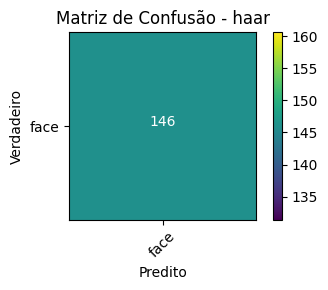

,modelo,accuracy,precision,recall,f1,avg_time,n,classes_presentes
0,haar,0.973333,1.0,0.973333,0.986486,0.020725,150,[face]


In [33]:
# =============================
# Execução de AVALIAÇÃO offline (após o fluxo de câmera)
# =============================
from pathlib import Path
import zipfile, urllib.request

# dataset default (você pode trocar o caminho aqui, se quiser)
try:
    DATA_DIR
except NameError:
    DATA_DIR = Path("cv_colab_data")
    DATA_DIR.mkdir(parents=True, exist_ok=True)
DEFAULT_DATASET_DIR = DATA_DIR / "dataset_default"
(DEFAULT_DATASET_DIR / "positives").mkdir(parents=True, exist_ok=True)
(DEFAULT_DATASET_DIR / "negatives").mkdir(parents=True, exist_ok=True)

def _download_and_unpack_zip(url: str, dest_root: Path) -> Path:
    """Baixa um .zip com positives/ e negatives/ e extrai para dest_root/'dataset_remote'."""
    zip_path = dest_root / "dataset_remote.zip"
    out_dir  = dest_root / "dataset_remote"
    print(f"Baixando dataset remoto: {url}")
    urllib.request.urlretrieve(url, str(zip_path))
    print(f"✔ zip salvo em: {zip_path}")
    # limpa extração anterior
    if out_dir.exists():
        import shutil; shutil.rmtree(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(str(zip_path), 'r') as zf:
        zf.extractall(str(out_dir))
    # achar a raiz com positives/ e negatives/
    def _find_ds(root: Path):
        if (root / "positives").is_dir() and (root / "negatives").is_dir():
            return root
        for p in root.rglob("*"):
            if p.is_dir() and (p / "positives").is_dir() and (p / "negatives").is_dir():
                return p
        return None
    ds = _find_ds(out_dir)
    if ds is None:
        raise ValueError("Zip não contém positives/ e negatives/.")
    print(f"✔ dataset encontrado em: {ds}")
    return ds

try:
    run_eval_auto = input(
        "Rodar avaliação offline (Automático/Default/Remoto)? [s/N]: "
    ).strip().lower() in ("s","sim","y","yes")
except Exception:
    run_eval_auto = False

if run_eval_auto:
    print("Fonte do dataset:")
    print("  1) Automático (enrollment + negatives persistentes/câmera)")
    print(f"  2) DEFAULT ({DEFAULT_DATASET_DIR})")
    print("  3) REMOTO/LOCAL existente (URL .zip ou caminho local)")
    choice = (input("Escolha [1/2/3]: ").strip() or "1")

    dataset_override = None
    default_dir = None

    if choice == "2":
        default_dir = DEFAULT_DATASET_DIR
        print(f"ℹ Usando dataset DEFAULT: {default_dir}")
    elif choice == "3":
        ds_input = input("Informe URL .zip OU caminho local com positives/ e negatives/: ").strip()
        if ds_input.startswith(("http://","https://")):
            dataset_override = _download_and_unpack_zip(ds_input, DATA_DIR)
        else:
            p = Path(ds_input)
            if not p.exists(): raise ValueError(f"Caminho não existe: {p}")
            if not ((p / "positives").is_dir() and (p / "negatives").is_dir()):
                raise ValueError(f"Caminho inválido (esperado positives/ e negatives/): {p}")
            dataset_override = p

    # Perguntas opcionais (as mesmas que você já tinha)
    try:
        use_camera = input("Usar câmera para completar negativos (apenas Automático)? [S/n]: ").strip().lower()
        use_camera = not (use_camera in ("n","nao","não"))
    except Exception:
        use_camera = True

    try:
        neg_src = input("Pasta extra com negativos (vazio = nenhuma): ").strip() or None
    except Exception:
        neg_src = None

    try:
        max_imgs = input("Limitar nº de imagens por classe? (vazio = sem limite): ").strip()
        max_imgs = int(max_imgs) if max_imgs else None
    except Exception:
        max_imgs = None

    try:
        th = input("Conf threshold (vazio = 0.5): ").strip()
        th = float(th) if th else 0.5
    except Exception:
        th = 0.5

    # Chamada final — agora com dataset_override e default_dataset_dir
    if dataset_override is not None:
        _ = run_offline_eval_from_enrollment(
            eval_max_images=max_imgs,
            conf_threshold=th,
            use_camera=False,
            negatives_src_dir=None,
            dataset_dir_override=dataset_override,   # usa dataset pronto
            default_dataset_dir=None,
        )
    elif default_dir is not None:
        _ = run_offline_eval_from_enrollment(
            eval_max_images=max_imgs,
            conf_threshold=th,
            use_camera=False,                        # default não captura; usa o que já houver lá
            negatives_src_dir=None,
            dataset_dir_override=None,
            default_dataset_dir=default_dir,         # usa dataset default
        )
    else:
        _ = run_offline_eval_from_enrollment(
            neg_target_min=30,
            capture_batch=30,
            capture_sleep_sec=0.15,
            eval_max_images=max_imgs,
            conf_threshold=th,
            use_camera=use_camera,                   # automático
            negatives_src_dir=neg_src,
            dataset_dir_override=None, # corrigido
            default_dataset_dir=None, # corrigido
        )